In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)


100%|██████████| 1.02G/1.02G [00:11<00:00, 98.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [2]:
import os
import shutil
from pathlib import Path

# Paths
source_folder = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'  # Replace with your source dataset folder
destination_folder ="test_images"
images_per_class = 50  # Number of images to copy per class

# Create the destination folder
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)
    if os.path.isdir(class_path):  # Check if it's a folder
        # Create a corresponding folder in the destination
        dest_class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_folder, exist_ok=True)

        # Get all image files in the class folder
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Sort images to maintain order and select the first 50
        selected_images = images[:images_per_class]

        # Copy selected images to the destination folder
        for img_name in selected_images:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(dest_class_folder, img_name)
            shutil.copy(src, dest)

print(f"Test dataset created successfully in '{destination_folder}'")


Test dataset created successfully in 'test_images'


In [3]:
import glob
from pathlib import Path

train_path = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
test_path  = 'test_images'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

train images
1738 	 blast
337 	 bacterial_panicle_blight
965 	 brown_spot
1088 	 tungro
1764 	 normal
1442 	 dead_heart
380 	 bacterial_leaf_streak
1594 	 hispa
479 	 bacterial_leaf_blight
620 	 downy_mildew
test images
50 	 blast
50 	 bacterial_panicle_blight
50 	 brown_spot
50 	 tungro
50 	 normal
50 	 dead_heart
50 	 bacterial_leaf_streak
50 	 hispa
50 	 bacterial_leaf_blight
50 	 downy_mildew


In [4]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [5]:
import os
from keras.models import Model
#from keras.optimizers import Adam
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
#from keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

#https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = MobileNet(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)

#     model.add(Dense(1024))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(n_classes))
#     model.add(Activation("softmax"))


    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (256, 256, 3)

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
model = create_model_mobilenet(input_shape, n_classes, optim_2, fine_tune=24)
model.summary()

<ipython-input-5-699fa1af2ec5>:27: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(include_top=False,


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 128, 128, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 128, 128, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 128, 128, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 128, 128, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 128, 128, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 128, 128, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 129, 129, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 64, 64, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 64, 64, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 64, 64, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 64, 64, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 70,349,002 (268.36 MB)

 Trainable params: 69,246,986 (264.16 MB)

 Non-trainable params: 1,102,016 (4.20 MB)

In [6]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 500 images belonging to 1 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
500


In [7]:
try:
    from livelossplot.inputs.keras import PlotLossesCallback
except:
    !pip install livelossplot

from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='mobilenet_model.weights.best.keras',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

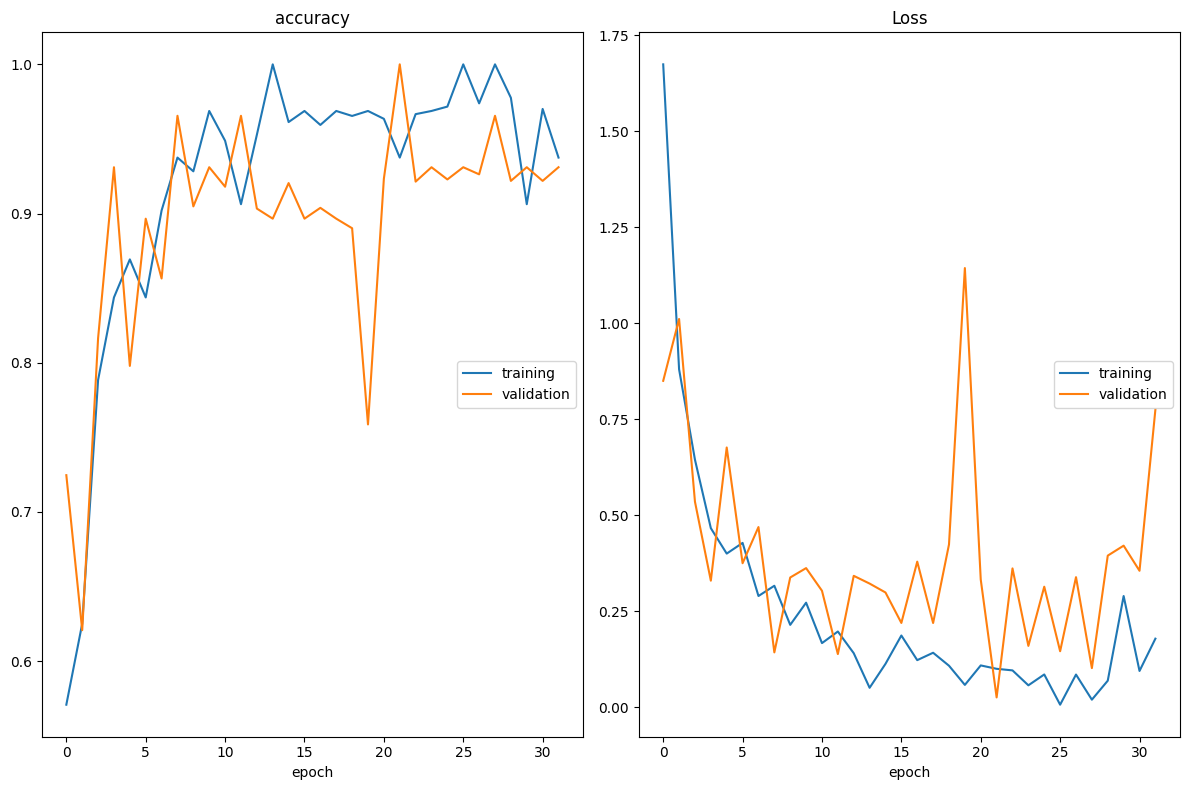

accuracy
	training         	 (min:    0.571, max:    1.000, cur:    0.938)
	validation       	 (min:    0.621, max:    1.000, cur:    0.931)
Loss
	training         	 (min:    0.007, max:    1.674, cur:    0.178)
	validation       	 (min:    0.026, max:    1.144, cur:    0.775)
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1785 - val_accuracy: 0.9310 - val_loss: 0.7749
CPU times: user 50min 35s, sys: 45.4 s, total: 51min 20s
Wall time: 50min 46s


In [8]:
%%time

plot_loss_2 = PlotLossesCallback()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Retrain model with fine-tuning
history = model.fit(train_generator,
                                  steps_per_epoch = STEP_SIZE_TRAIN,
                                  validation_data = valid_generator,
                                  validation_steps = STEP_SIZE_VALID,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1,epochs=EPOCHS)

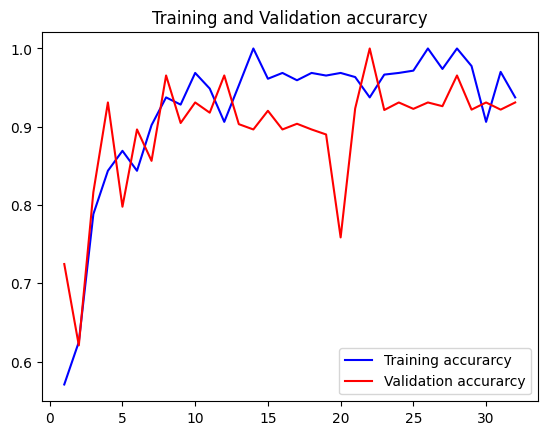

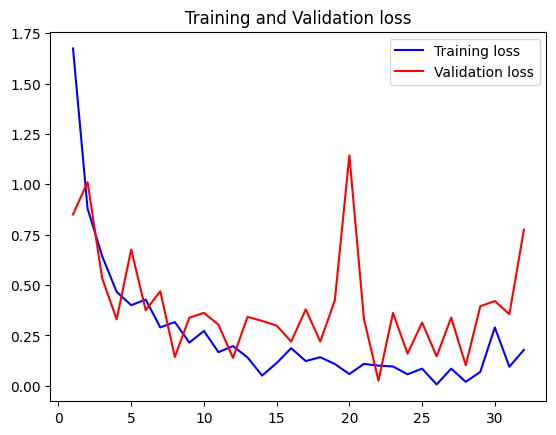

CPU times: user 432 ms, sys: 235 ms, total: 666 ms
Wall time: 521 ms


In [9]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_mobilenet_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [10]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
50 	 blast
50 	 bacterial_panicle_blight
50 	 brown_spot
50 	 tungro
50 	 normal
50 	 dead_heart
50 	 bacterial_leaf_streak
50 	 hispa
50 	 bacterial_leaf_blight
50 	 downy_mildew
Found 500 images belonging to 10 classes.


In [11]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('mobilenet_model.weights.best.keras')
pred = model.predict(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("mobilenet Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

mobilenet Model Accuracy : 98.60%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    1.00000   0.92000   0.95833        50
   bacterial_leaf_streak    1.00000   1.00000   1.00000        50
bacterial_panicle_blight    1.00000   1.00000   1.00000        50
                   blast    0.98039   1.00000   0.99010        50
              brown_spot    0.94231   0.98000   0.96078        50
              dead_heart    1.00000   1.00000   1.00000        50
            downy_mildew    1.00000   0.98000   0.98990        50
                   hispa    0.98000   0.98000   0.98000        50
                  normal    1.00000   1.00000   1.00000        50
                  tungro    0.96154   1.00000   0.98039        50

                accuracy                        0.98600       500
               macro avg    0.98642   0.98600   0.98595       500
            weighted avg    0.98642   0.98600   0.98595       500



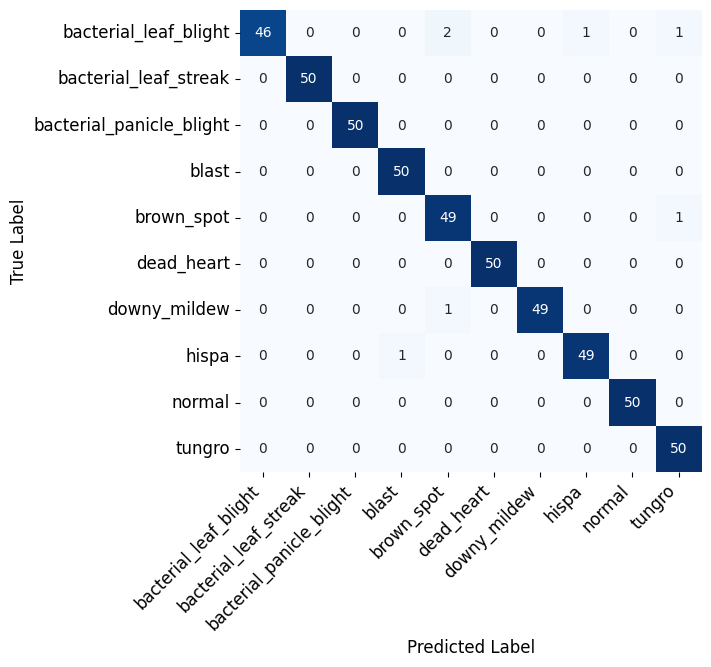

[[46  0  0  0  2  0  0  1  0  1]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 49  0  0  0  0  1]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  1  0 49  0  0  0]
 [ 0  0  0  1  0  0  0 49  0  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 50]]


In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [14]:
loss, acc = model.evaluate(valid_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.9322 - loss: 0.3002  


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


0.9335579872131348 0.29304245114326477


In [15]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
brown_spot,52
tungro,52
blast,51
bacterial_panicle_blight,50
bacterial_leaf_streak,50
hispa,50
normal,50
dead_heart,50
downy_mildew,49
bacterial_leaf_blight,46


In [16]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100582.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100681.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100956.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/101394.jpg,brown_spot
4,bacterial_leaf_blight/101485.jpg,hispa
